In [63]:
import json
import os
import pandas as pd
import string

import pyspark
from pyspark.sql import SQLContext
from pyspark.ml.feature import CountVectorizer as CountVectorizer_pyspark
from pyspark.ml.feature import IDF 
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation
import nltk, re
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim

stopwords = set(nltk.corpus.stopwords.words('english'))
model_path = '/home/elia/Dropbox/Harrisburg/ANLY_610/codes/models/wordvec/'
data_path = '/home/elia/Dropbox/Harrisburg/ANLY_610/codes/data/'

In [44]:
def load_webhouse_data(data_name): 
    data_file = data_path + data_name + '.json'
    with open(data_file) as json_data:
        data = json.load(json_data)
        return data
    
data = load_webhouse_data('trump_clean')

## Scikit-Learn

In [10]:
def tokenize_titles(title):
    tokens = nltk.word_tokenize(title)
    lmtzr = WordNetLemmatizer()
    filtered_tokens = []
    
    for token in tokens:
        token = token.replace("'s", " ").replace("n’t", " not").replace("’ve", " have")
        token = re.sub(r'[^a-zA-Z0-9 ]', '', token)
        if token not in stopwords:
            filtered_tokens.append(token.lower())
    
    lemmas = [lmtzr.lemmatize(t,'v') for t in filtered_tokens]

    return lemmas

In [11]:
def clstr_lda(num_topics, stories):
    # top words to be identified
    n_top_words = 10

    tf_vectorizer = CountVectorizer(max_df=100, min_df=2, max_features=500,
                                    tokenizer=tokenize_titles, ngram_range=(3,4))

    tf = tf_vectorizer.fit_transform(stories)

    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=200,
                                    learning_method='batch', learning_offset=10.,
                                    random_state = 1)
    lda.fit(tf)
    tf_feature_names = tf_vectorizer.get_feature_names()

    # print top topic words
    topics = dict()
    for topic_idx, topic in enumerate(lda.components_):
        topics[topic_idx] = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("Topic #%d:" % topic_idx)
        print(" | ".join([tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
    return topics

In [7]:
feed_titles = []

for feed in data:
    feed_titles.append(str(feed['title']))

In [12]:
topics = clstr_lda(10, feed_titles)

Topic #0:
budget deficit balloon | washington seem care | deficit balloon  | deficit balloon  washington | budget deficit balloon  | balloon  washington |  washington seem care |  washington seem | relate president trump stand | relate president trump
Topic #1:
trump 2020 budget |  86b wall | budget seek  |  impeachment  | trump worth  | wacky nut job | nut job  | seek  86 | wacky nut job  | seek  86 billion
Topic #2:
   | daylight save time |     | seek fund border wall | seek fund border | trump budget seek | budget seek fund border | budget seek fund | trump budget seek fund | make daylight save time
Topic #3:
powell say trump | sign bibles  | trump sign bibles  | president trump  | attack play role | attack play role rate | play role rate | play role rate pause | role rate pause | say trump  
Topic #4:
ask congress  | trump ask congress | budget  trump | congress  86 | ask congress  86 | congress  86 billion |  trump ask | trump ask congress  | massage parlor owner | budget  trump 

## PySpark

In [3]:
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'

In [4]:
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [5]:
# load json 
def load_json_data(data_name): 
    data_file = data_path + data_name + '.json'
    return sqlContext.read.json(data_file)

data_df = load_json_data('trump_clean')

In [12]:
descriptions = data_df.rdd.map(lambda x : x['title']).filter(lambda x: x is not None)
lmtzr = WordNetLemmatizer()
tokens = descriptions.map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in stopwords])    \
    .map( lambda word: [lmtzr.lemmatize(x,'v') for x in word]).zipWithIndex()
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words", "index"])

In [13]:
df_txts.show()

+--------------------+-----+
|       list_of_words|index|
+--------------------+-----+
|[look, back, impe...|    0|
|[white, house, ch...|    1|
|[force, secretary...|    2|
|[trump, tout, low...|    3|
|[awareness, sharp...|    4|
|[trump, partied, ...|    5|
|[president, trump...|    6|
|[migrant, father,...|    7|
|[jimmy, carter, o...|    8|
|[president, trump...|    9|
|[trump, survey, a...|   10|
|   [light, sentence]|   11|
|[awareness, sharp...|   12|
|[afghan, ambassad...|   13|
|[aide, get, diffe...|   14|
|[luna, county, si...|   15|
|[bullish, denucle...|   16|
|[trump, survey, d...|   17|
|[lawyer, say, tru...|   18|
|[cohen, accuse, l...|   19|
+--------------------+-----+
only showing top 20 rows



In [31]:
# TF
cv = CountVectorizer_pyspark(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)

In [32]:
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [33]:
result_tfidf.show()

+--------------------+-----+--------------------+--------------------+
|       list_of_words|index|        raw_features|            features|
+--------------------+-----+--------------------+--------------------+
|[look, back, impe...|    0|(897,[92,209,268,...|(897,[92,209,268,...|
|[white, house, ch...|    1|(897,[0,7,8,48,49...|(897,[0,7,8,48,49...|
|[force, secretary...|    2|(897,[13,39,48,78...|(897,[13,39,48,78...|
|[trump, tout, low...|    3|(897,[0,174,305,4...|(897,[0,174,305,4...|
|[awareness, sharp...|    4|(897,[165,299,304...|(897,[165,299,304...|
|[trump, partied, ...|    5|(897,[0,127,144,1...|(897,[0,127,144,1...|
|[president, trump...|    6|(897,[0,6,78,505,...|(897,[0,6,78,505,...|
|[migrant, father,...|    7|(897,[4,43,56,148...|(897,[4,43,56,148...|
|[jimmy, carter, o...|    8|(897,[20,38,80,25...|(897,[20,38,80,25...|
|[president, trump...|    9|(897,[0,6,15,19,5...|(897,[0,6,15,19,5...|
|[trump, survey, a...|   10|(897,[0,15,19,31,...|(897,[0,15,19,31,...|
|   [l

In [34]:
import time

num_topics = 12
max_iterations = 50
start = time.time()
lda_model = LDA.train(result_tfidf.select('index','features').rdd.mapValues(Vectors.fromML).map(list), k=num_topics, maxIterations=max_iterations)
print("Time to train LDA" + str(time.time() - start))

Time to train LDA42.12013292312622


In [35]:
wordNumbers = 15  
topicIndices = sc.parallelize(lda_model.describeTopics(maxTermsPerTopic = wordNumbers))
topic_list = topicIndices.toDF().select('*').collect()
for i in range(0,11):
    print("Topic cluster: ", i)
    for index in topic_list[i]._1:
        print(cvmodel.vocabulary[index])

Topic cluster:  0
border
wall
seek
fund
billion
budget
call
space
request
congress
report
fight
expect
include
money
Topic cluster:  1
deficit
must
migrant
washington
care
thousands
talk
seem
government
immigration
kid
tie
massage
identify
parent
Topic cluster:  2
vote
issue
mueller
base
exaggerate
also
back
juice
probe
tell
founder
hate
republicans
face
reason
Topic cluster:  3
news
administration
manafort
sentence
give
paul
leaders
want
proposal
former
science
fresh
california
religious
ally
Topic cluster:  4
budget
democrats
propose
trump
cut
another
battle
set
military
program
milwaukee
party
convention
presidential
boost
Topic cluster:  5
stop
sanders
press
week
trump
push
emergency
democratic
focus
host
fire
defense
india
envoy
foreign
Topic cluster:  6
judge
force
plan
resign
campaign
bill
families
separate
secretary
shine
get
post
authority
extend
business
Topic cluster:  7
trade
china
deal
offer
ilhan
omar
world
summit
state
obama
invite
record
address
look
third
Topic cluster

In [36]:
topics = lda_model.describeTopics(maxTermsPerTopic = 10)
for x, topic in enumerate(topics):
    print('TOPIC #: ' + str(x))
    words = topic[0]
    weights = topic[1]
    for n in range(len(words)):
        print(cvmodel.vocabulary[words[n]] + ' ' + str(weights[n]))
    print()

TOPIC #: 0
border 0.09699211630827033
wall 0.0833727897424367
seek 0.06568035266128809
fund 0.05514589990284444
billion 0.048307263915208086
budget 0.04655291552126202
call 0.03384149712910465
space 0.033838837001878064
request 0.0318420081931457
congress 0.0314303204196599

TOPIC #: 1
deficit 0.044789746164458105
must 0.03746360123843716
migrant 0.03670930189459144
washington 0.03577400748358722
care 0.029832382286441143
thousands 0.029706516497079408
talk 0.028315812408319565
seem 0.02731955054486768
government 0.02620451736937121
immigration 0.025679527684963795

TOPIC #: 2
vote 0.04375417255904
issue 0.038931600006503
mueller 0.03380831649566757
base 0.03212507155836489
exaggerate 0.03059946322809138
also 0.029564512883121702
back 0.028983386846744764
juice 0.028780042228474287
probe 0.026066962454249717
tell 0.026034031983684064

TOPIC #: 3
news 0.08342682838411226
administration 0.044502573592641176
manafort 0.041413726589820656
sentence 0.03563832254953979
give 0.029597553410094

## Gensim 

In [55]:
titles = [[data[i]['title'], data[i]['published'][:10]]  for i in range(len(data))]
df_feeds = pd.DataFrame(titles,columns=['title', 'date'])
df_feeds.head()

,title,date
0,A look back at Clinton's impeachment reveals t...,2019-03-08
1,White House dy chief of Staff resigns to join ...,2019-03-09
2,U.S. Air Force Secretary Heather Wilson Plans ...,2019-03-08
3,"Trump touts lower aluminum prices, but America...",2019-03-08
4,#MeToo Awareness Sharpens Focus On Pay Equity,2019-03-08


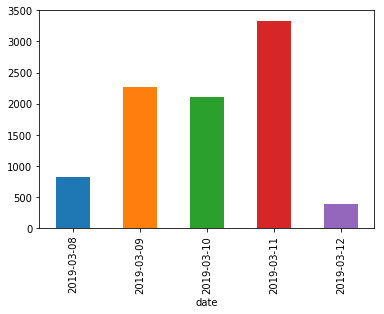

In [57]:
df_daily_count = df_feeds.groupby('date')['title'].count()
df_daily_count.plot(kind='bar', x='date')

In [64]:
punctuation = set(string.punctuation) 
def text_cleanup(input_text):
    one = " ".join([i for i in input_text.lower().split() if i not in stopwords])
    two = "".join(re.sub(r'[^a-zA-Z ]', '', i) for i in one if i not in punctuation)
    three = [WordNetLemmatizer().lemmatize(i) for i in two.split()]
    return three

In [70]:
titles = df_feeds[['title']].applymap(text_cleanup)['title']
dictionary = Dictionary(titles)
dictionary.filter_extremes(no_below=10, no_above=0.8)
corpora = [dictionary.doc2bow(doc) for doc in titles]

# Running and Trainign LDA model on the document term matrix.
lda_model = ldamodel.LdaModel(corpora, num_topics=8, id2word = dictionary, passes=50)

In [71]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      14.938213        1       1  0.190962 -0.026582
5      14.749077        1       2 -0.041331  0.169504
4      12.796124        1       3  0.022367 -0.155464
3      12.534489        1       4 -0.085767 -0.093883
6      12.088526        1       5 -0.067926 -0.183978
7      11.131075        1       6  0.297540  0.083852
2      11.083928        1       7 -0.166896 -0.046032
1      10.678566        1       8 -0.148949  0.252582, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
118   Default  1534.000000         budget  1534.000000  30.0000  30.0000
324   Default   807.000000           wall   807.000000  29.0000  29.0000
137   Default   751.000000         border   751.000000  28.0000  28.0000
449   Default   410.000000           seek   410.000000  27.0000  27.0000
11    Default   535.000000          house   535.000000  26.0000  26.0000
290   Default   339.000000         pelosi   339.000000  25.0000  25.0000
74    Default   368.000000           time   368.000000  24.0000  24.0000
16    Default   453.000000          white   453.000000  23.0000  23.0000
556   Default   257.000000            tim   257.000000  22.0000  22.0000
734   Default   260.000000        funding   260.000000  21.0000  21.0000
602   Default   274.000000            cut   274.000000  20.0000  20.0000
764   Default   269.000000        billion   269.000000  19.0000  19.0000
126   Default   234.000000          apple   234.000000  18.0000  18.0000
772   Default   215.000000         saving   215.000000  17.0000  17.0000
685   Default   217.000000             it   217.000000  16.0000  16.0000
221   Default   470.000000            new   470.000000  15.0000  15.0000
228   Default   210.000000       spending   210.000000  14.0000  14.0000
1149  Default   205.000000          worth   205.000000  13.0000  13.0000
162   Default   355.000000       democrat   355.000000  12.0000  12.0000
56    Default   191.000000          north   191.000000  11.0000  11.0000
536   Default   188.000000  investigation   188.000000  10.0000  10.0000
100   Default   172.000000          trade   172.000000   9.0000   9.0000
54    Default   183.000000          korea   183.000000   8.0000   8.0000
87    Default   171.000000          first   171.000000   7.0000   7.0000
49    Default   769.000000            say   769.000000   6.0000   6.0000
597   Default   170.000000        deficit   170.000000   5.0000   5.0000
445   Default   195.000000        request   195.000000   4.0000   4.0000
59    Default   174.000000          bible   174.000000   3.0000   3.0000
122   Default   177.000000          judge   177.000000   2.0000   2.0000
58    Default   173.000000        alabama   173.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
25     Topic8    75.147682       american    76.006409   2.2256  -4.4007
180    Topic8    72.285690           need    73.144234   2.2251  -4.4395
393    Topic8    64.136116            tie    64.995003   2.2236  -4.5592
742    Topic8    63.600582         schiff    64.459129   2.2235  -4.5676
956    Topic8    60.938393        weekend    61.796860   2.2229  -4.6103
953    Topic8    55.930889          fresh    56.789421   2.2217  -4.6961
540    Topic8    54.542286         crisis    55.400799   2.2213  -4.7212
738    Topic8    52.523346           good    53.381916   2.2207  -4.7589
952    Topic8    44.501900        florian    45.360149   2.2178  -4.9246
955    Topic8    44.501900            von    45.360149   2.2178  -4.9246
954    Topic8    44.501900        henckel    45.360149   2.2178  -4.9246
951    Topic8    44.501900   donnersmarck    45.360149   2.2178  -4.9246
1044   Topic8    42.559204        invited    43.419136   2.2169  -4.9693
1160   Topic8    38.551815        subsidy    39.410225   2.